In [12]:
import matplotlib.pyplot as plt

In [13]:
from inception_blocks_v2 import *
from fr_utils import *
from pathlib import Path
import cv2 as cv
from mtcnn.mtcnn import MTCNN
import numpy as np
from tensorflow.keras import backend as K


def triplet_loss(y_true, y_pred, alpha=0.2):
    """
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(np.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(np.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(0.0, basic_loss))
    return loss


def face_detector():
    K.set_image_data_format('channels_last')
    model = MTCNN()
    return model


def face_recognizer():
    print('loading FR - ', K.image_data_format())
    K.set_image_data_format('channels_first')
    model = faceRecoModel(input_shape=(3, 96, 96))
    model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
    load_weights_from_FaceNet(model)
    print('Done loading FR - ', K.image_data_format())
    return model


def get_faces_(image, detector, f=6):
    shape = image.shape
    face_points = detector.detect_faces(image)
    faces = np.empty((len(face_points), 96, 96, 3), dtype='uint8')
    for i, pt in enumerate(face_points):
        x, y, w, h = pt['box']
        ZX = int(w/f)
        ZY = int(h/f)
        xa = max(x - ZX, 0)
        xb = min(x + w + ZX, shape[1])
        ya = max(y - ZY, 0)
        yb = min(y + h + ZY, shape[0])
        face = image[ya: yb, xa: xb]
        face = cv.resize(face, (96, 96), interpolation=cv.INTER_AREA)
        faces[i] = face
    return faces

def get_faces(image, classifier, f=6):
    shape = image.shape
    face_points = classifier.detectMultiScale(image)
    faces = np.empty((len(face_points), 96, 96, 3), dtype='uint8')
    for i, pt in enumerate(face_points):
        x, y, w, h = pt
        ZX = int(w/f)
        ZY = int(h/f)
        xa = max(x - ZX, 0)
        xb = min(x + w + ZX, shape[1])
        ya = max(y - ZY, 0)
        yb = min(y + h + ZY, shape[0])
        face = image[ya: yb, xa: xb]
        face = cv.resize(face, (96, 96), interpolation=cv.INTER_AREA)
        faces[i] = face
    return faces


def get_dist(image1, image2, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".

    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras

    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    # K.set_image_data_format('channels_first')
    encoding1 = img_to_encoding(image1, model)
    encoding2 = img_to_encoding(image2, model)
    dist = np.linalg.norm(np.subtract(encoding1, encoding2))
#     dist = 1 - np.dot(encoding1.reshape(-1), encoding2.reshape(-1))
    if dist < 0.7:
        print('Welcome in!')
        door_open = True
    else:
        print('Please go away')
        door_open = False

    return dist, door_open

In [19]:
classifier = face_detector()
# classifier = cv.CascadeClassifier(str(Path(cv.data.haarcascades) / 'haarcascade_frontalface_default.xml'))
recognizer = face_recognizer()

loading FD -  channels_last
Done loading FD -  channels_last
loading FR -  channels_last
Done loading FR -  channels_first


In [15]:
img = cv.imread('test/me.jpg')[:, :, ::-1]

In [20]:
faces1 = get_faces_(img, classifier, f=1)
faces2 = get_faces_(img, classifier, f=5)

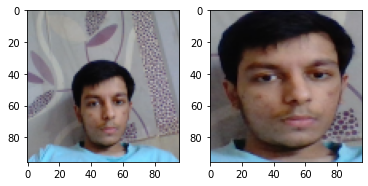

In [21]:
plt.subplots(1, 2)
plt.subplot(121)
plt.imshow(faces1[0])
plt.subplot(122)
plt.imshow(faces2[0]);

In [22]:
encoding1 = img_to_encoding(faces1[0], recognizer)
encoding2 = img_to_encoding(faces2[0], recognizer)
dist = np.linalg.norm(np.subtract(encoding1, encoding2))
print(1 - np.dot(encoding1.reshape(-1), encoding2.reshape(-1)))
print(dist)

0.379491925239563
0.87119675


In [63]:
def show(a, b, f):
    def g(name):
        img = cv.imread(f'test/{name}.jpg', 1)[:, :, ::-1]
        img_fliped =  cv.flip(img, 1)
        return (img, img_fliped)
    
    img1, img1_fliped = g(a)
    img2, img2_fliped = g(b)
    
#     img1 = cv.imread(f'test/{a}.jpg', 1)[:, :, ::-1]
#     img1_fliped = cv.flip(img1, 1)
#     img2 = cv.imread(f'test/{b}.jpg', 1)[:, :, ::-1]
#     img2_fliped = cv.flip(img2, 1)
    
    faces1 = get_faces_(img1, classifier, f=f)
    faces2 = get_faces_(img1_fliped, classifier, f=f)
    faces3 = get_faces_(img2, classifier, f=f)
    faces4 = get_faces_(img2_fliped, classifier, f=f)
    
    # print('1 and 2 - ', get_dist(image1, image2, None, recognizer))
    print('1 and 3 - ', get_dist(faces1[0], faces3[0], None, recognizer))
    print('1 and 4 - ', get_dist(faces1[0], faces4[0], None, recognizer))
    print('2 and 3 - ', get_dist(faces2[0], faces3[0], None, recognizer))
    print('2 and 4 - ', get_dist(faces2[0], faces4[0], None, recognizer))

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(faces1[0])
    ax[1].imshow(faces3[0])

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(faces1[0])
    ax[1].imshow(faces4[0])

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(faces2[0])
    ax[1].imshow(faces3[0])

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(faces2[0])
    ax[1].imshow(faces4[0]);

Welcome in!
1 and 3 -  (0.60326, True)
Welcome in!
1 and 4 -  (0.6114378, True)
Welcome in!
2 and 3 -  (0.5967987, True)
Welcome in!
2 and 4 -  (0.6635369, True)


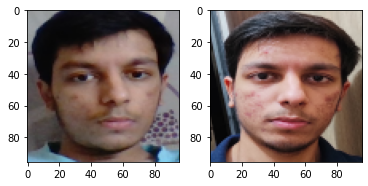

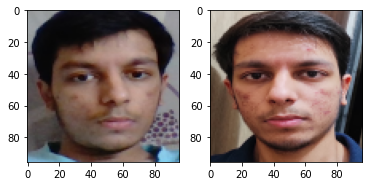

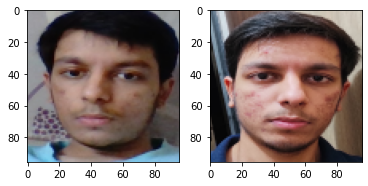

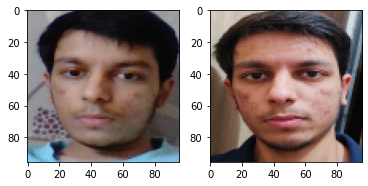

In [64]:
show('me', '3', 6)

Welcome in!
1 and 3 -  (0.63580954, True)
Please go away
1 and 4 -  (0.7183597, False)
Welcome in!
2 and 3 -  (0.6637705, True)
Please go away
2 and 4 -  (0.8288063, False)


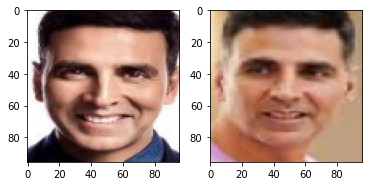

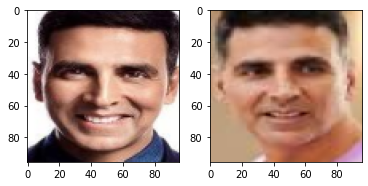

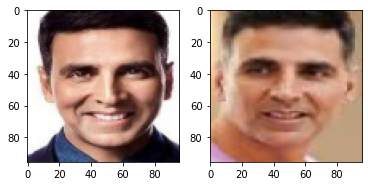

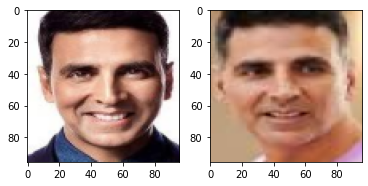

In [65]:
show('ak', 'ak3', 6)

Welcome in!
1 and 3 -  (0.6067146, True)
Please go away
1 and 4 -  (0.8493096, False)
Welcome in!
2 and 3 -  (0.6478032, True)
Please go away
2 and 4 -  (0.869052, False)


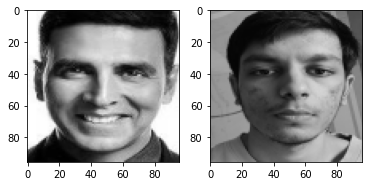

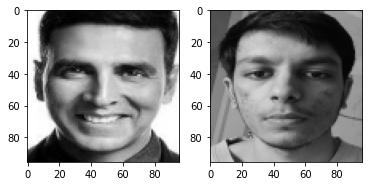

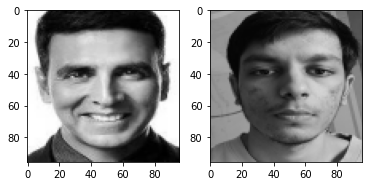

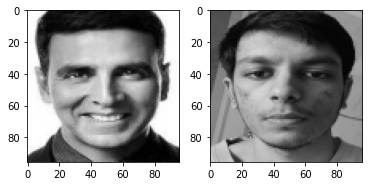

In [54]:
show('ak', 'a', 6)

Welcome in!
1 and 3 -  (0.6704798, True)
Welcome in!
1 and 4 -  (0.6829212, True)
Welcome in!
2 and 3 -  (0.41475922, True)
Welcome in!
2 and 4 -  (0.42895353, True)


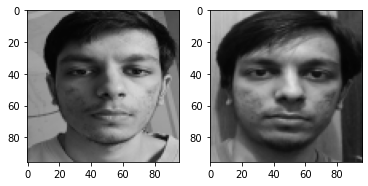

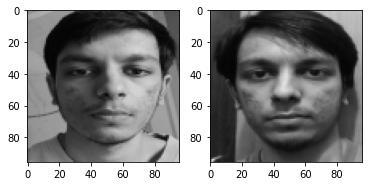

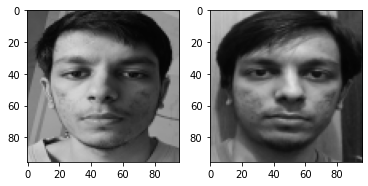

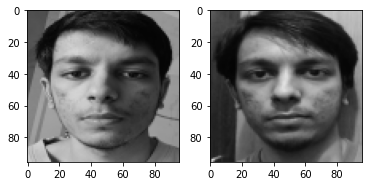

In [55]:
show('a', 'me2', 6)

Welcome in!
1 and 3 -  (0.69189805, True)
Please go away
1 and 4 -  (0.7788092, False)
Please go away
2 and 3 -  (0.7709959, False)
Please go away
2 and 4 -  (0.75233346, False)


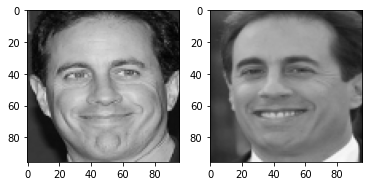

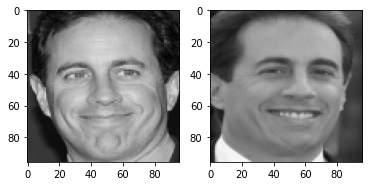

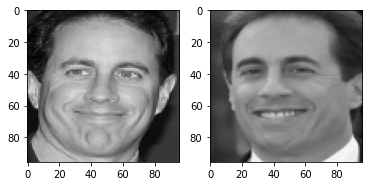

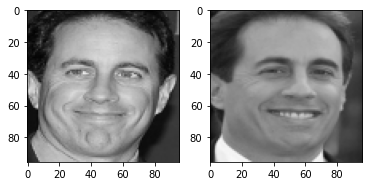

In [56]:
show('cel', 'cel2', 6)

Welcome in!
1 and 3 -  (0.5951707, True)
Please go away
1 and 4 -  (0.716103, False)
Please go away
2 and 3 -  (0.87452704, False)
Please go away
2 and 4 -  (0.94596815, False)


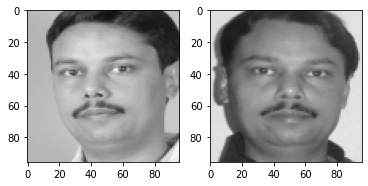

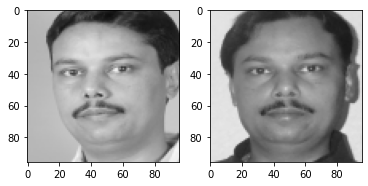

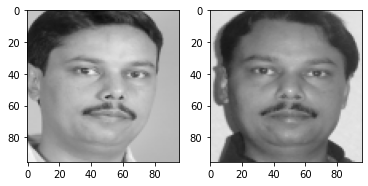

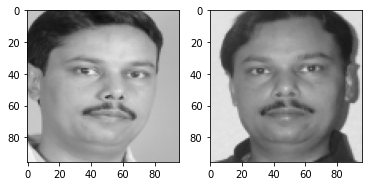

In [57]:
show('pap', 'pap3', f=6)

Welcome in!
1 and 3 -  (0.65128994, True)
Welcome in!
1 and 4 -  (0.6990506, True)
Please go away
2 and 3 -  (0.9197506, False)
Please go away
2 and 4 -  (0.7490453, False)


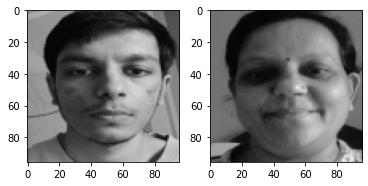

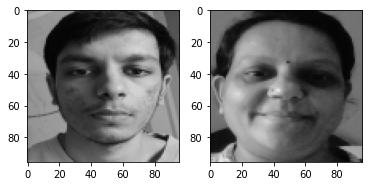

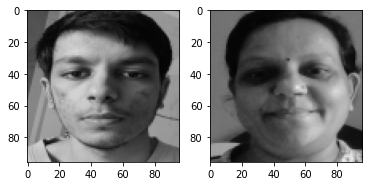

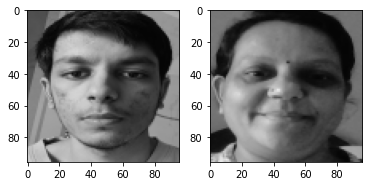

In [58]:
show('a', 'mom', f=6)

Please go away
1 and 3 -  (1.0111918, False)
Please go away
1 and 4 -  (1.0059589, False)
Please go away
2 and 3 -  (1.0792416, False)
Please go away
2 and 4 -  (1.0998819, False)


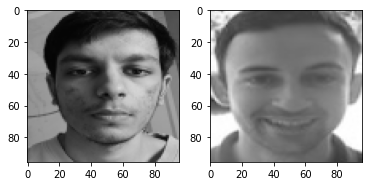

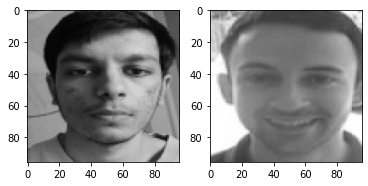

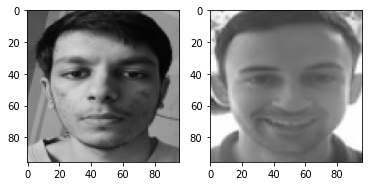

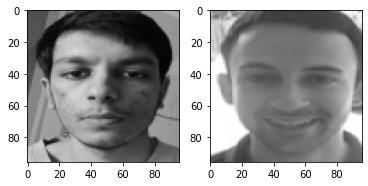

In [59]:
show('a', 'camera_0', f=6)

Welcome in!
1 and 3 -  (0.6473724, True)
Welcome in!
1 and 4 -  (0.5268367, True)
Welcome in!
2 and 3 -  (0.68687755, True)
Welcome in!
2 and 4 -  (0.49312407, True)


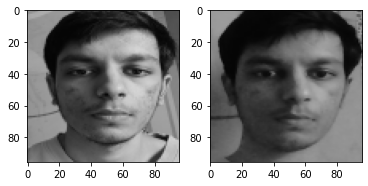

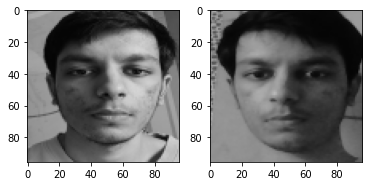

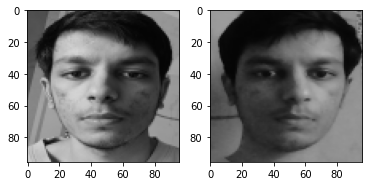

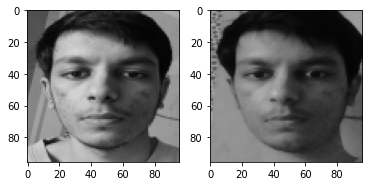

In [60]:
show('a', 'me3', f=6)

Please go away
1 and 3 -  (0.8073435, False)
Please go away
1 and 4 -  (0.75512224, False)
Please go away
2 and 3 -  (0.84730697, False)
Please go away
2 and 4 -  (0.8269548, False)


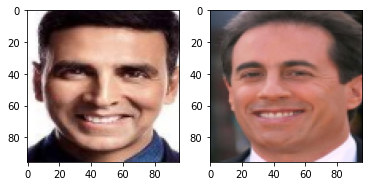

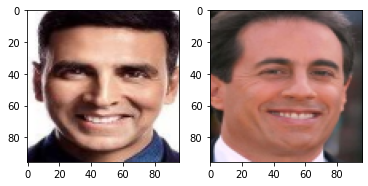

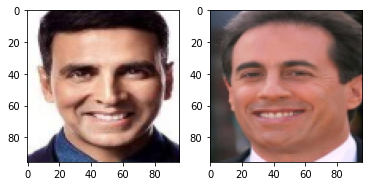

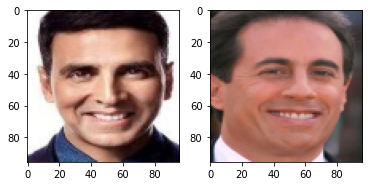

In [36]:
show('ak', 'cel2', f=6)

Please go away
1 and 3 -  (0.70504516, False)
Welcome in!
1 and 4 -  (0.62144035, True)
Welcome in!
2 and 3 -  (0.4585822, True)
Welcome in!
2 and 4 -  (0.41938737, True)


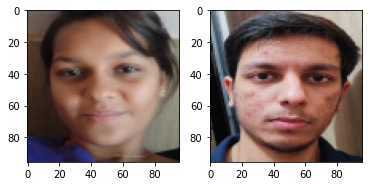

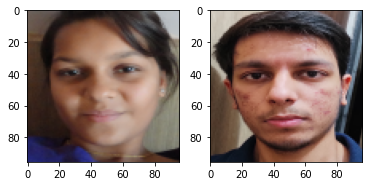

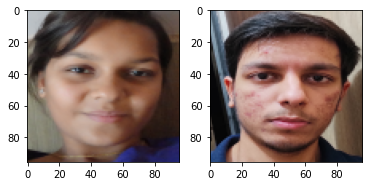

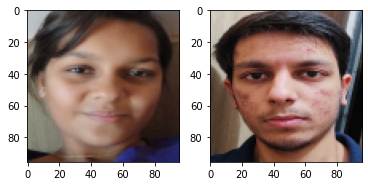

In [37]:
show('unn', '3', f=6)

Please go away
1 and 3 -  (0.7037752, False)
Please go away
1 and 4 -  (0.72499645, False)
Welcome in!
2 and 3 -  (0.6237622, True)
Please go away
2 and 4 -  (0.73264647, False)


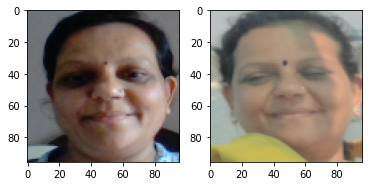

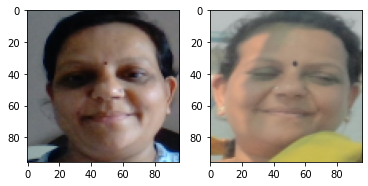

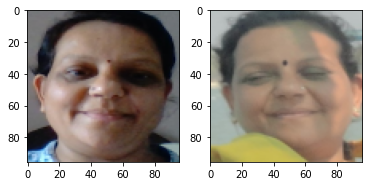

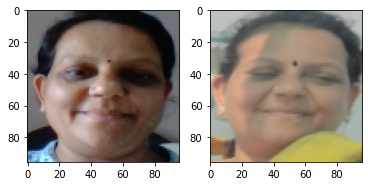

In [38]:
show('mom', 'mom2', f=6)

Please go away
1 and 3 -  (0.7670045, False)
Welcome in!
1 and 4 -  (0.62061125, True)
Welcome in!
2 and 3 -  (0.67088103, True)
Welcome in!
2 and 4 -  (0.59041494, True)


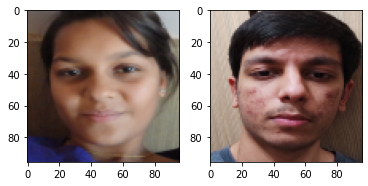

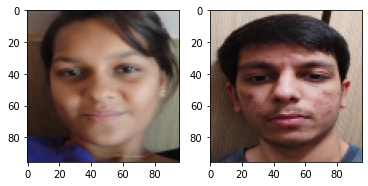

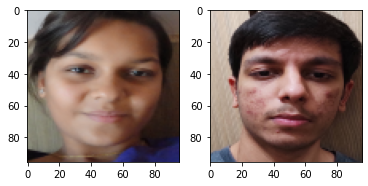

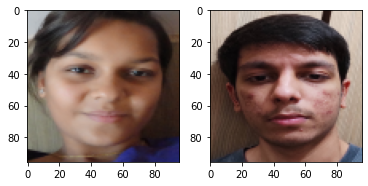

In [39]:
show('unn', 'z3', f=6)

Welcome in!
1 and 3 -  (0.5052612, True)
Welcome in!
1 and 4 -  (0.6105076, True)
Please go away
2 and 3 -  (0.7621845, False)
Please go away
2 and 4 -  (0.88524, False)


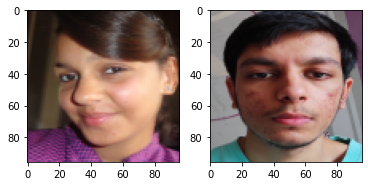

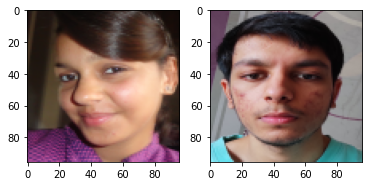

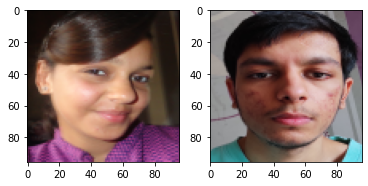

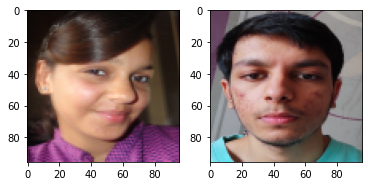

In [70]:
show('unn2', 'a', f=6)

Please go away
1 and 3 -  (0.78226453, False)
Please go away
1 and 4 -  (0.86284846, False)
Please go away
2 and 3 -  (0.7832736, False)
Please go away
2 and 4 -  (0.8500187, False)


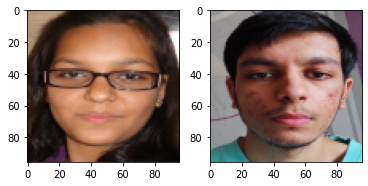

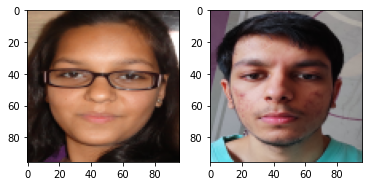

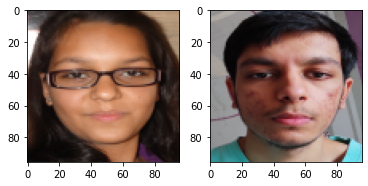

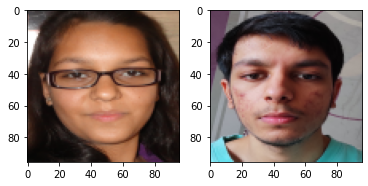

In [71]:
show('unn3', 'a', f=6)

Please go away
1 and 3 -  (0.723778, False)
Please go away
1 and 4 -  (0.81518114, False)
Welcome in!
2 and 3 -  (0.66493696, True)
Please go away
2 and 4 -  (0.7341747, False)


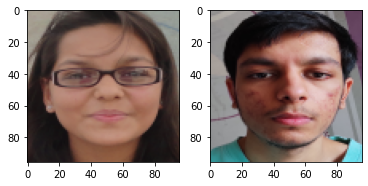

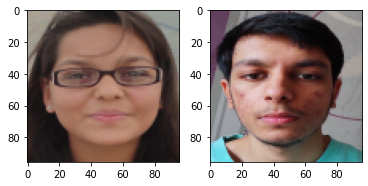

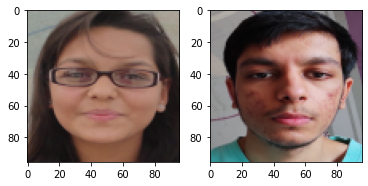

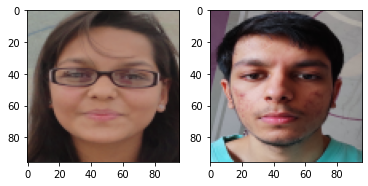

In [73]:
show('unn4', 'a', f=6)

Please go away
1 and 3 -  (1.0931816, False)
Please go away
1 and 4 -  (1.239731, False)
Please go away
2 and 3 -  (0.81094146, False)
Please go away
2 and 4 -  (0.980045, False)


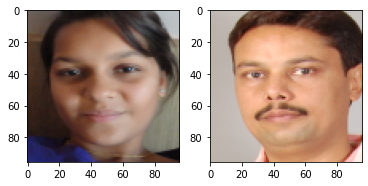

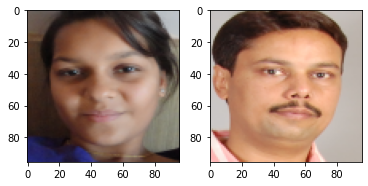

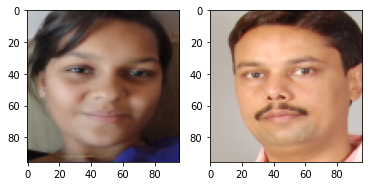

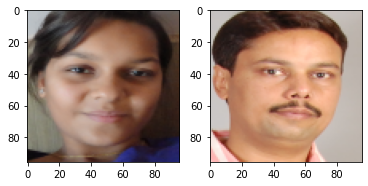

In [40]:
show('unn', 'pap', f=6)

Welcome in!
1 and 3 -  (0.65128994, True)
Welcome in!
1 and 4 -  (0.6990506, True)
Please go away
2 and 3 -  (0.9197506, False)
Please go away
2 and 4 -  (0.7490453, False)


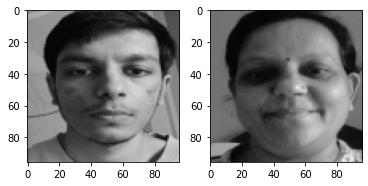

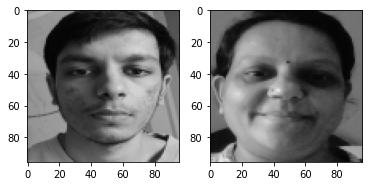

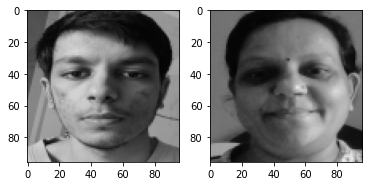

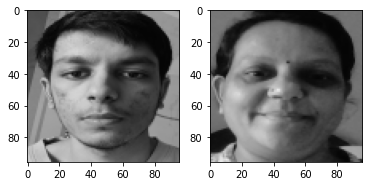

In [62]:
show('a', 'mom', f=6)

Welcome in!
1 and 3 -  (0.610664, True)
Please go away
1 and 4 -  (0.7370736, False)
Welcome in!
2 and 3 -  (0.50936663, True)
Welcome in!
2 and 4 -  (0.56958544, True)


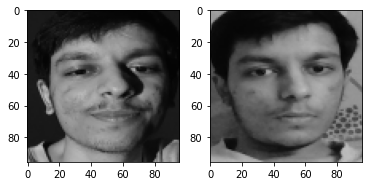

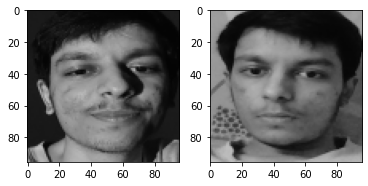

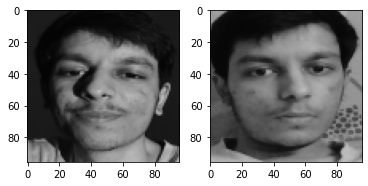

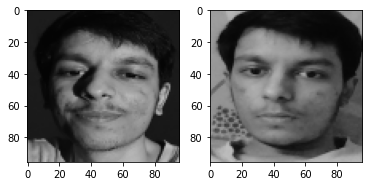

In [61]:
show('z', 'me', f=6)